In [1]:
import tensorflow as tf
import gpflow as gpf
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
from gpflow.utilities.model_utils import add_noise_cov
from model.model_trainer import ModelTrainer

In [2]:
from gpflow.models.util import data_input_to_tensor

In [3]:
def fh1(x):
    return np.power(6 * x - 2, 2) * np.sin(12 * x - 4) + 10


def fh2(x):
    return 1.5 * (x + 2.5) * np.sqrt(fh1(x))


def fh3(x):
    return 5 * x * x * np.sin(12 ** x)


def fl1(x):
    return 2 * (x + 2) * np.sqrt(fh1(x) - 1.3 * (np.power(6 * x - 2, 2) - 6 * x))


def fl2(x):
    return np.power(6 * x - 2, 2) * np.sin(8 * x - 4) + 10 - (np.power(6 * x - 2, 2) - 6 * x)


def fl3(x):
    return fh3(x) + (x * x * x * np.sin(3 * x - 0.5)) + 4 * np.cos(2 * x)


fh = [fh1, fh2, fh3]
fl = [fl1, fl2, fl3]

In [4]:
sampler = qmc.LatinHypercube(d=1)
sample_hf = sampler.random(n=6).transpose()[0]
sample_lf = sampler.random(n=12).transpose()[0]

In [5]:
xl = sample_lf.reshape(sample_lf.shape[0], 1)
# xl = sample_lf[:len(sample_hf)].reshape(sample_hf.shape[0], 1)
xh = sample_hf.reshape(sample_hf.shape[0], 1)

In [6]:
X = np.vstack((
        np.hstack((xl, np.zeros_like(xl), np.zeros_like(xl))),
        np.hstack((xl, np.ones_like(xl), np.zeros_like(xl))),
        np.hstack((xl, np.ones_like(xl) * 2, np.zeros_like(xl))),
        np.hstack((xh, np.zeros_like(xh), np.ones_like(xh))),
        np.hstack((xh, np.ones_like(xh), np.ones_like(xh))),
        np.hstack((xh, np.ones_like(xh) * 2, np.ones_like(xh)))
))

Y = np.vstack((
        np.hstack((fl1(xl), np.zeros_like(xl), np.zeros_like(xl))),
        np.hstack((fl2(xl), np.ones_like(xl), np.zeros_like(xl))),
        np.hstack((fl3(xl), np.ones_like(xl) * 2, np.zeros_like(xl))),
        np.hstack((fh1(xh), np.zeros_like(xh), np.ones_like(xh))),
        np.hstack((fh2(xh), np.ones_like(xh), np.ones_like(xh))),
        np.hstack((fh3(xh), np.ones_like(xh) * 2, np.ones_like(xh)))
))

In [7]:
X_augmented = np.vstack((np.hstack((x, np.zeros_like(x))), np.hstack((x, np.ones_like(x))), np.hstack((x, np.ones_like(x) * 2))))
Y_augmented = np.vstack((np.hstack((fl1(x), np.zeros_like(x))), np.hstack((fl2(x), np.ones_like(x))), np.hstack((fl3(x), np.ones_like(x) * 2))))
Xh_augmented = np.vstack((np.hstack((xh, np.zeros_like(xh))), np.hstack((xh, np.ones_like(xh))), np.hstack((xh, np.ones_like(xh) * 2))))
Yh_augmented = np.vstack((np.hstack((fh1(xh), np.zeros_like(xh))), np.hstack((fh2(xh), np.ones_like(xh))), np.hstack((fh3(xh), np.ones_like(xh) * 2))))
Xl_augmented = np.vstack((np.hstack((xl, np.zeros_like(xl))), np.hstack((xl, np.ones_like(xl))), np.hstack((xl, np.ones_like(xl) * 2))))
Yl_augmented = np.vstack((np.hstack((fl1(xh), np.zeros_like(xh))), np.hstack((fl2(xh), np.ones_like(xh))), np.hstack((fl3(xh), np.ones_like(xh) * 2))))

NameError: name 'x' is not defined

In [7]:
class DiffModel(gpf.models.GPModel, gpf.models.InternalDataTrainingLossMixin):

    def __init__(self, data, kernel: gpf.kernels.Kernel, likelihood: gpf.likelihoods.Likelihood, num_examples, num_outputs, lo_fi_var):
        super().__init__(kernel, likelihood, num_latent_gps=1)
        self.num_examples = num_examples
        self.num_outputs = num_outputs
        self.data = data
        self.lo_fi_var = lo_fi_var

        self.rho = gpf.Parameter(tf.ones((int(num_examples * num_outputs), 1)))

    def predict_f(self, Xnew, full_cov: bool = False, full_output_cov: bool = False):
        X, Y, _, _ = self.data
        Ktt = self.kernel(Xnew)
        Ktn = self.kernel(Xnew, X)
        Knn = self.kernel(X)
        
        var = self.get_variance(self.num_examples)
        
        Knnvar = Knn + var
        
        mean = Ktn @ tf.linalg.inv(Knnvar) @ tf.expand_dims(Y[:, 0], axis=1)
        
        variance = Ktt - Ktn @ tf.linalg.inv(Knnvar) @ tf.transpose(Ktn)
        
        return mean, variance
        
    def get_variance(self, size) -> tf.Tensor:
        variances = [likelihood.variance for likelihood in self.likelihood.likelihoods]
        n = int(size)
        return tf.linalg.diag(tf.concat(
                [tf.linalg.diag_part(tf.fill((n, n), variance)) for variance in variances], 
            axis=0))

    def maximum_log_likelihood_objective(self) -> tf.Tensor:
        X_hi_fi, Y_hi_fi, X_lo_fi, Y_lo_fi = self.data
        K = self.kernel(X_hi_fi)
        Y_hi_fi = tf.expand_dims(Y_hi_fi[:, 0], axis=1)
        Y_lo_fi = tf.expand_dims(Y_lo_fi[:, 0], axis=1)
        d = Y_hi_fi - tf.math.multiply(self.rho, Y_lo_fi)
        hi_fi_var = self.get_variance(self.num_examples)
        var = hi_fi_var - tf.math.multiply(self.rho, self.lo_fi_var)

        Kvar = K + var
        d_Kvar_d = tf.linalg.matrix_transpose(d) @ tf.linalg.inv(Kvar) @ d
        log_det = tf.linalg.logdet(Kvar)
        
        return -tf.reduce_sum(0.5 * (d_Kvar_d + log_det + self.num_examples * tf.cast(self.num_examples * tf.math.log(2*np.pi), dtype=tf.float64)))

In [8]:
class MultiTaskGaussianProcess(gpf.models.GPModel, gpf.models.InternalDataTrainingLossMixin):

    def __init__(self, data, kernel: gpf.kernels.Kernel, likelihood: gpf.likelihoods.Likelihood, num_examples, num_outputs):
        super().__init__(kernel, likelihood, num_latent_gps=1)
        self.num_examples = num_examples
        self.num_outputs = num_outputs
        self.data = data

    def predict_f(self, Xnew, full_cov: bool = False, full_output_cov: bool = False):
        X, Y = self.data
        Ktt = self.kernel(Xnew)
        Ktn = self.kernel(Xnew, X)
        Knn = self.kernel(X)
        
        var = self.get_variance(self.num_examples)
        
        Knnvar = Knn + var
        
        mean = Ktn @ tf.linalg.inv(Knnvar) @ tf.expand_dims(Y[:, 0], axis=1)
        
        variance = Ktt - Ktn @ tf.linalg.inv(Knnvar) @ tf.transpose(Ktn)
        
        return mean, variance
        
    def get_variance(self, size) -> tf.Tensor:
        variances = [likelihood.variance for likelihood in self.likelihood.likelihoods]
        n = int(size)
        return tf.linalg.diag(tf.concat(
                [tf.linalg.diag_part(tf.fill((n, n), variance)) for variance in variances], 
            axis=0))
        

    def maximum_log_likelihood_objective(self) -> tf.Tensor:
        X, Y = self.data
        X_lo_fi = tf.gather_nd(indices=tf.where(X[:, -1] == 0), params=X[:, :-1])
        print(X_lo_fi)
        Y_lo_fi = tf.gather_nd(indices=tf.where(Y[:, -1] == 0), params=Y[:, :-1])
        X_hi_fi = tf.gather_nd(indices=tf.where(X[:, -1] == 1), params=X[:, :-1])
        Y_hi_fi = tf.gather_nd(indices=tf.where(Y[:, -1] == 1), params=Y[:, :-1])
                
        lo_fi_loss = self.calculate_loss(X_lo_fi, Y_lo_fi)
        hi_fi_loss = self.calculate_loss(X_hi_fi, Y_hi_fi)
        
        return tf.constant(0.75, dtype=tf.float64) * hi_fi_loss + tf.constant(0.25, dtype=tf.float64) * lo_fi_loss
        
        
    def calculate_loss(self, X, Y) -> tf.Tensor:
        K = self.kernel(X)
        var = self.get_variance(X.shape[0] / self.num_outputs)
        Kvar = K + var

        d_Kvar_d = tf.expand_dims(Y[:, 0], axis=0) @ tf.linalg.inv(Kvar) @ tf.expand_dims(Y[:, 0], axis=1)
        log_det = tf.linalg.logdet(Kvar)
        
        return -tf.reduce_sum(0.5 * (d_Kvar_d + log_det + tf.cast(X.shape[0] / self.num_outputs * tf.math.log(2*np.pi), dtype=tf.float64)))
    

In [10]:
class ModelTrainer:
    MAXITER = 10000

    VALID_MODEL_NAMES = ['multi-task-gp', 'VGP', 'GPR', 'GPMC', 'difference']
    VALID_OPTIMIZERS = ['scipy']
    VALID_KERNEL_NAMES = ['RBF', 'Matern12', 'Matern32', 'Matern52', 'ArcCosine', 'Coregion', 'White']
    VALID_LIKELIHOOD_NAMES = ['Gaussian', 'Exponential', 'StudentT', 'Gamma', 'Beta']

    def __init__(self, model_name, optimizer_name, kernel_names, likelihood_name, X_lo_fi, Y_lo_fi, num_outputs, X_hi_fi=None, Y_hi_fi=None, sigma=None):
        self.num_data, self.num_dim = X_hi_fi.shape if X_hi_fi is not None else X_lo_fi.shape
        self.num_outputs = num_outputs
        
        self.sigma = sigma

        if X_hi_fi is None:
            self.data = (X_lo_fi, Y_lo_fi)
        else:
            self.data = (X_hi_fi, Y_hi_fi, X_lo_fi, Y_lo_fi)

        self.kernel = gpf.kernels.Product([self.get_kernel(kern, i) for i, kern in enumerate(kernel_names)])
        self.likelihood = gpf.likelihoods.SwitchedLikelihood(
            [self.get_likelihood(likelihood_name) for _ in range(self.num_outputs)])

        self.optimizer = self.get_optimizer(optimizer_name)
        self.model = self.get_model(model_name)

    def get_likelihood(self, likelihood_name: str) -> gpf.likelihoods.ScalarLikelihood:
        if isinstance(likelihood_name, gpf.likelihoods.ScalarLikelihood):
            return likelihood_name
        if likelihood_name == 'Gaussian':
            return gpf.likelihoods.Gaussian()
        if likelihood_name == 'Exponential':
            return gpf.likelihoods.Exponential()
        if likelihood_name == 'StudentT':
            return gpf.likelihoods.StudentT()
        if likelihood_name == 'Gamma':
            return gpf.likelihoods.Gamma()
        if likelihood_name == 'Beta':
            return gpf.likelihoods.Beta()
        raise Exception(
            f"Please enter a valid likelihood name. {likelihood_name} is not in {self.VALID_LIKELIHOOD_NAMES}.")

    def get_kernel(self, kernel_name: str, i: int) -> gpf.kernels.Kernel:
        if isinstance(kernel_name, gpf.kernels.Kernel):
            return kernel_name
        if kernel_name == 'RBF':
            return gpf.kernels.RBF(active_dims=[0])
        if kernel_name == 'Matern12':
            return gpf.kernels.Matern12(active_dims=[0])
        if kernel_name == 'Matern32':
            return gpf.kernels.Matern32(active_dims=[0])
        if kernel_name == 'Matern52':
            return gpf.kernels.Matern52(active_dims=[0])
        if kernel_name == 'ArcCosine':
            return gpf.kernels.ArcCosine(active_dims=[0])
        if kernel_name == 'Coregion':
            kernel = gpf.kernels.Coregion(output_dim=self.num_outputs, rank=self.num_dim, active_dims=[1])
            kernel.W = np.random.rand(self.num_outputs, self.num_dim)
            return kernel
        if kernel_name == 'White':
            return gpf.kernels.White()
        raise Exception(
            f"Please make sure all kernels are valid. {kernel_name} is not one of {self.VALID_KERNEL_NAMES}.")

    def get_model(self, model_name) -> gpf.models.GPModel:
        if isinstance(model_name, gpf.models.GPModel):
            return model_name
        if model_name == 'multi-task-gp':
            return MultiTaskGaussianProcess(self.data, kernel=self.kernel, likelihood=self.likelihood, num_examples=self.num_data / 3, num_outputs=self.num_outputs)
        if model_name == 'VGP':
            return gpf.models.VGP(self.data, kernel=self.kernel, likelihood=self.likelihood,
                                  num_latent_gps=1)
        if model_name == 'GPR':
            return gpf.models.GPR(self.data, kernel=self.kernel)
        if model_name == 'GPMC':
            return gpf.models.GPMC(self.data, kernel=self.kernel, likelihood=self.likelihood, num_latent_gps=1)
        if model_name == 'difference':
            return DiffModel(self.data, kernel=self.kernel, likelihood=self.likelihood, num_examples=self.num_data / 3, num_outputs=self.num_outputs, lo_fi_var=self.sigma)
        raise Exception(f"Please enter a valid model name: one of {self.VALID_MODEL_NAMES}")

    def get_optimizer(self, optimizer_name):
        if optimizer_name == 'scipy':
            return gpf.optimizers.Scipy()
        if optimizer_name == 'adam':
            return tf.optimizers.Adam()
        raise Exception(f"Please enter a valid optimizer name: one of {self.VALID_OPTIMIZERS}")

    def train_model(self):
        if isinstance(self.optimizer, gpf.optimizers.Scipy):
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html for information
            self.optimizer.minimize(self.model.training_loss,
                                    variables=self.model.trainable_variables,
                                    options=dict(disp=True),
                                    method="L-BFGS-B")
            tf.print("Done training model!")
        else:
            tf_optimization_step = tf.function(self.optimization_step)
            for epoch in range(self.MAXITER):
                loss = tf_optimization_step()
                epoch_id = epoch + 1
                if epoch_id % (self.MAXITER // 100) == 0:
                    tf.print(f"Epoch {epoch_id}: Loss (train) {loss}")
            tf.print("Done training model!")
                    
    def optimization_step(self):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.model.training_loss()
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def predict(self, X_test):
        mean, var = self.model.predict_f(X_test)
        return mean, var
    
    def get_model_sigma(self, size):
        return self.model.get_variance(size)

In [9]:
trainer = ModelTrainer(
    model_name='multi-task-gp', 
    optimizer_name='scipy', 
    kernel_names=['RBF', 'Coregion'], 
    likelihood_name='Gaussian',
    X_lo_fi=X,
    Y_lo_fi=Y,
    num_outputs=3,
    X_hi_fi=None,
    Y_hi_fi=None
)

In [10]:
trainer.train_model()

TypeError: in user code:

    File "c:\users\jackp\pycharmprojects\triumf_gaussian_process\venv\lib\site-packages\gpflow\optimizers\scipy.py", line 120, in _tf_eval  *
        loss, grads = _compute_loss_and_gradients(
    File "c:\users\jackp\pycharmprojects\triumf_gaussian_process\venv\lib\site-packages\gpflow\optimizers\scipy.py", line 223, in _compute_loss_and_gradients  *
        loss = loss_closure()
    File "c:\users\jackp\pycharmprojects\triumf_gaussian_process\venv\lib\site-packages\gpflow\models\training_mixins.py", line 60, in training_loss  *
        return self._training_loss()  # type: ignore
    File "c:\users\jackp\pycharmprojects\triumf_gaussian_process\venv\lib\site-packages\gpflow\models\model.py", line 54, in _training_loss  *
        return -(self.maximum_log_likelihood_objective(*args, **kwargs) + self.log_prior_density())
    File "C:\Users\jackp\PycharmProjects\triumf_gaussian_process\model\multi_task_gp.py", line 50, in maximum_log_likelihood_objective  *
        lo_fi_loss = self.calculate_loss(X_lo_fi, Y_lo_fi)
    File "C:\Users\jackp\PycharmProjects\triumf_gaussian_process\model\multi_task_gp.py", line 57, in calculate_loss  *
        var = self.get_variance(X.shape[0] / self.num_outputs)

    TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'


In [104]:
diff_trainer = ModelTrainer(
    model_name='difference', 
    optimizer_name='scipy', 
    kernel_names=['RBF', 'Coregion'], 
    likelihood_name='Gaussian',
    X_lo_fi=Xl_augmented,
    Y_lo_fi=Yl_augmented,
    num_outputs=3,
    X_hi_fi=Xh_augmented,
    Y_hi_fi=Yh_augmented,
    sigma=trainer.get_model_sigma(6)
)

In [105]:
diff_trainer.model

name,class,transform,prior,trainable,shape,dtype,value
DiffModel.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
DiffModel.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
DiffModel.kernel.kernels[1].kappa,Parameter,Softplus,,True,"(3,)",float64,[1. 1. 1.]
DiffModel.likelihood.likelihoods[0].variance,Parameter,Softplus + Shift,,True,(),float64,1.0
DiffModel.likelihood.likelihoods[1].variance,Parameter,Softplus + Shift,,True,(),float64,1.0
DiffModel.likelihood.likelihoods[2].variance,Parameter,Softplus + Shift,,True,(),float64,1.0
DiffModel.rho,Parameter,Identity,,True,"(18, 1)",float64,[[1....


In [106]:
diff_trainer.train_model()

Done training model!


In [107]:
diff_trainer.model

name,class,transform,prior,trainable,shape,dtype,value
DiffModel.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,116929832.06637716
DiffModel.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,21134210170.25118
DiffModel.kernel.kernels[1].kappa,Parameter,Softplus,,True,"(3,)",float64,[0.00000000e+00 3.66254867e+09 0.00000000e+00]
DiffModel.likelihood.likelihoods[0].variance,Parameter,Softplus + Shift,,True,(),float64,1e-06
DiffModel.likelihood.likelihoods[1].variance,Parameter,Softplus + Shift,,True,(),float64,1e-06
DiffModel.likelihood.likelihoods[2].variance,Parameter,Softplus + Shift,,True,(),float64,1e-06
DiffModel.rho,Parameter,Identity,,True,"(18, 1)",float64,[[3.09527396e+10...


In [108]:
xtest = np.linspace(0, 1, 10)[:,None]
mu, var = diff_trainer.predict(np.hstack((xtest, np.ones_like(xtest))))

InvalidArgumentError: {{function_node __wrapped__MatrixInverse_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is not invertible. [Op:MatrixInverse]

In [ ]:
print(mu - var)

In [109]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(x[:, 0],
                     (mu - 2*var)[:, 0],
                     (mu + 2*var)[:, 0],
                     color=color, alpha=0.4)

def plot_lf(m):
    plt.figure(figsize=(8, 4))
    xtest = np.linspace(0, 1, 100)[:,None]
    line, = plt.plot(sample_lf, fl1(sample_lf), 'x', mew=2)
    mu, var = m.predict(np.hstack((xtest, np.zeros_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color(), 'Y1')

    line, = plt.plot(sample_lf, fl2(sample_lf), 'x', mew=2)
    mu, var = m.predict(np.hstack((xtest, np.ones_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color(), 'Y2')
    
    line, = plt.plot(sample_lf, fl3(sample_lf), 'x', mew=2)
    mu, var = m.predict(np.hstack((xtest, np.ones_like(xtest) * 2)))
    plot_gp(xtest, mu, var, line.get_color(), 'Y3')

    plt.legend()
    
def plot_hf(m):
    plt.figure(figsize=(8, 4))
    xtest = np.linspace(0, 1, 1000)[:,None]
    line, = plt.plot(sample_hf, fh1(sample_hf), 'x', mew=2)
    mu, var = m.predict(np.hstack((xtest, np.zeros_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color(), 'Y1')

    line, = plt.plot(sample_hf, fh2(sample_hf), 'x', mew=2)
    mu, var = m.predict(np.hstack((xtest, np.ones_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color(), 'Y2')
    
    line, = plt.plot(sample_hf, fh3(sample_hf), 'x', mew=2)
    mu, var = m.predict(np.hstack((xtest, np.ones_like(xtest) * 2)))
    plot_gp(xtest, mu, var, line.get_color(), 'Y3')

    plt.legend()

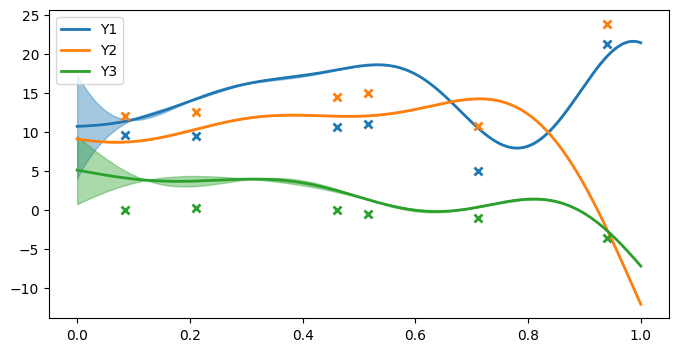

In [112]:
plot_hf(trainer)

In [87]:
tf.config.run_functions_eagerly(True)